# Benchmarking

In [ ]:
! wget -P ./data https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv
df = pd.read_csv('./data/dataset_v1.csv')
df = df[df['SPLIT'] == 'test']
df.to_csv('./data/test_dataset.csv', index=None)
test_dataset = df['SMILES'].tolist()

In [31]:
! mkdir metrics

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘sampling’: File exists
mkdir: cannot create directory ‘metrics’: File exists


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle
from moses.utils import CharVocab
import torch
from rdkit.Chem import Draw
if torch.cuda.is_available():
  torch.cuda.set_device(0)

## Pretrain Benchmarking

In [ ]:
import moses
df = pd.read_csv('./data/test_dataset.csv')
test_dataset = df['SMILES'].tolist()
df = pd.read_csv('./data/moses_qed_props.csv.gz', compression="gzip")
train_dataset = df['SMILES'].tolist()
df = pd.read_csv('./sampling/pretrain_sampled_100k.csv', names=['SMILES'])
pretrain_generated = df['SMILES'].tolist()

metrics = moses.metrics.get_all_metrics(pretrain_generated, test=test_dataset, train=train_dataset,device='cuda:0')
# use cpu:
#metrics = moses.metrics.get_all_metrics(pretrain_generated, test=test_dataset, train=train_dataset)

In [ ]:
df_metrics = pd.DataFrame(metrics, index=[0])
df_metrics

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,Scaf/TestSF,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty
0,1.0,1.0,1.0,4.58905,0.435965,0.953083,0.552581,4.751993,0.429373,0.956308,0.188032,0.860888,0.855572,0.901724,0.345298,0.459071,0.009907,7.291159,0.997676


## RL Benchmarking

In [ ]:
import moses
df = pd.read_csv('./data/test_dataset.csv')
test_dataset = df['SMILES'].tolist()
df = pd.read_csv('./data/moses_qed_props.csv.gz', compression="gzip")
train_dataset = df['SMILES'].tolist()

for i in range(1,11):
  df = pd.read_csv(f'./sampling/rl_sampled_{i}.csv', names=['SMILES'])
  rl_generated = df['SMILES'].tolist()
  metrics = moses.metrics.get_all_metrics(rl_generated, test=test_dataset, train=train_dataset,device='cuda:0')
  #metrics = moses.metrics.get_all_metrics(rl_generated, test=test_dataset, train=train_dataset)
  print(f"Computed metrics 30000 * {i}")
  pickle.dump(metrics, open( f"./metrics/metrics_{i}.pkl", "wb" ) )

In [ ]:
for i in range(1,11):
  metrics = pickle.load(open(f"./metrics/metrics_{i}.pkl", "rb"))
  df_next = pd.DataFrame(metrics, index=[0])
  if i >= 2:
    df = df.append(df_next, ignore_index=True)
  else:
    df = df_next

df = df.append(df.agg(["mean", "std"]))
df

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,Scaf/TestSF,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty
0,1.0,1.0,0.99940,6.804628,0.506926,0.924628,0.382764,6.875765,0.496554,0.925707,0.081055,0.819689,0.812964,0.931978,0.164010,0.053564,0.032261,9.783475,0.989093
1,1.0,1.0,0.99980,6.853032,0.507982,0.924144,0.375328,6.924470,0.497382,0.925367,0.081572,0.819406,0.812686,0.929367,0.156645,0.048149,0.032479,9.968086,0.990241
2,1.0,1.0,0.99990,6.868988,0.508181,0.922074,0.381971,6.941782,0.497892,0.923446,0.081574,0.819796,0.813053,0.934105,0.158675,0.051270,0.031856,10.124522,0.989607
3,1.0,1.0,0.99960,6.868886,0.507400,0.922833,0.372035,6.937062,0.496834,0.924050,0.089586,0.819780,0.813006,0.930316,0.165397,0.050039,0.032550,10.134066,0.989254
4,1.0,1.0,0.99940,6.817941,0.507479,0.923248,0.390237,6.900873,0.496849,0.924382,0.088235,0.819667,0.812920,0.931819,0.168178,0.049355,0.032565,10.034019,0.990598
5,1.0,1.0,0.99950,6.797841,0.508378,0.924218,0.402962,6.881704,0.497913,0.925345,0.081359,0.819472,0.812731,0.931757,0.162395,0.047510,0.033492,9.829127,0.989694
6,1.0,1.0,0.99990,6.831954,0.509042,0.923898,0.390356,6.898824,0.498870,0.925057,0.091690,0.819491,0.812719,0.932625,0.153457,0.048920,0.033279,10.019620,0.989661
7,1.0,1.0,0.99950,6.875872,0.508173,0.923552,0.372876,6.944069,0.497635,0.924759,0.083222,0.819214,0.812488,0.932341,0.152398,0.050962,0.033102,9.919929,0.989973
8,1.0,1.0,0.99950,6.782962,0.507720,0.924374,0.392403,6.853110,0.497164,0.925815,0.082058,0.820070,0.813341,0.933132,0.161859,0.050085,0.032225,9.741765,0.988844
9,1.0,1.0,0.99980,6.820719,0.507808,0.923677,0.400459,6.887418,0.497134,0.924953,0.083250,0.819668,0.812936,0.932769,0.161571,0.051793,0.032263,9.806920,0.989134


## Compute Sampling QED

In [ ]:
from rdkit import rdBase, Chem
from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors, MolFromSmiles
from moses.metrics import QED, SA, logP, weight

In [ ]:
def rule_of_five(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    if (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10):
        return 1
    else:
        return 0

In [ ]:
for i in range(1,11):
  df = pd.read_csv(f'./sampling/rl_sampled_{i}.csv', names=['smiles'])
  df['logP'] = df['smiles'].apply(lambda x: logP(MolFromSmiles(x)))
  df['SA'] = df['smiles'].apply(lambda x: SA(MolFromSmiles(x)))
  df['QED'] = df['smiles'].apply(lambda x: QED(MolFromSmiles(x)))
  df['weight'] = df['smiles'].apply(lambda x: weight(MolFromSmiles(x)))
  df['Lipinski'] = df['smiles'].apply(lambda x: rule_of_five(MolFromSmiles(x)))
  print(f"Computed QED 30000 * {i}")
  df.to_csv(f'./sampling/rl_sampled_QED_{i}.csv', index=None)

Computed QED 30000 * 1
Computed QED 30000 * 2
Computed QED 30000 * 3
Computed QED 30000 * 4
Computed QED 30000 * 5
Computed QED 30000 * 6
Computed QED 30000 * 7
Computed QED 30000 * 8
Computed QED 30000 * 9
Computed QED 30000 * 10


In [ ]:
for i in range(1,11):
  df_s = pd.read_csv(f'./sampling/rl_sampled_QED_{i}.csv')
  df_next = pd.DataFrame(df_s.mean()).transpose()
  if i >= 2:
    df = df.append(df_next, ignore_index=True)
  else:
    df = df_next

df = df.append(df.agg(["mean", "std"]))
df

,logP,SA,QED,weight,Lipinski
0,2.308057,2.486495,0.838881,297.659904,0.997658
1,2.314996,2.481387,0.839098,297.404060,0.997301
2,2.311697,2.482099,0.838477,297.247518,0.997243
3,2.302961,2.483834,0.839164,297.208340,0.996840
4,2.299393,2.485346,0.839182,297.306958,0.997593
5,2.305592,2.479607,0.840113,297.642294,0.997962
6,2.312941,2.482951,0.839895,297.347491,0.998132
7,2.314712,2.481458,0.839720,297.494127,0.997615
8,2.306947,2.485575,0.838842,297.712116,0.997188
9,2.311165,2.486116,0.838884,297.661286,0.997010


# Sampling Benchmarking

In [ ]:
from rdkit import rdBase, Chem
from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors, MolFromSmiles
from moses.metrics import QED, SA, logP, weight

In [ ]:
def rule_of_five(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    if (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10):
        return 1
    else:
        return 0

In [ ]:
df = pd.read_csv("./sampling/rl_sampled_100k_sorted.csv")
df['logP'] = df['smiles'].apply(lambda x: logP(MolFromSmiles(x)))
df['SA'] = df['smiles'].apply(lambda x: SA(MolFromSmiles(x)))
df['QED'] = df['smiles'].apply(lambda x: QED(MolFromSmiles(x)))
df['weight'] = df['smiles'].apply(lambda x: weight(MolFromSmiles(x)))
df['Lipinski'] = df['smiles'].apply(lambda x: rule_of_five(MolFromSmiles(x)))

df.to_csv('./sampling/rl_sampled_100k_sorted_QED.csv', index=None)

In [57]:
import seaborn as sns
from moses.metrics import QED, SA, logP, weight
from rdkit.Chem import MolFromSmiles
df = pd.read_csv("./sampling/rl_sampled_100k_sorted_QED.csv")
df_mean = pd.DataFrame(df.mean()).transpose()
df_mean

,reward,logP,SA,QED,weight,Lipinski
0,7.915028,2.316684,2.493975,0.838656,297.875079,0.997373


In [37]:
import warnings
warnings.filterwarnings('ignore')

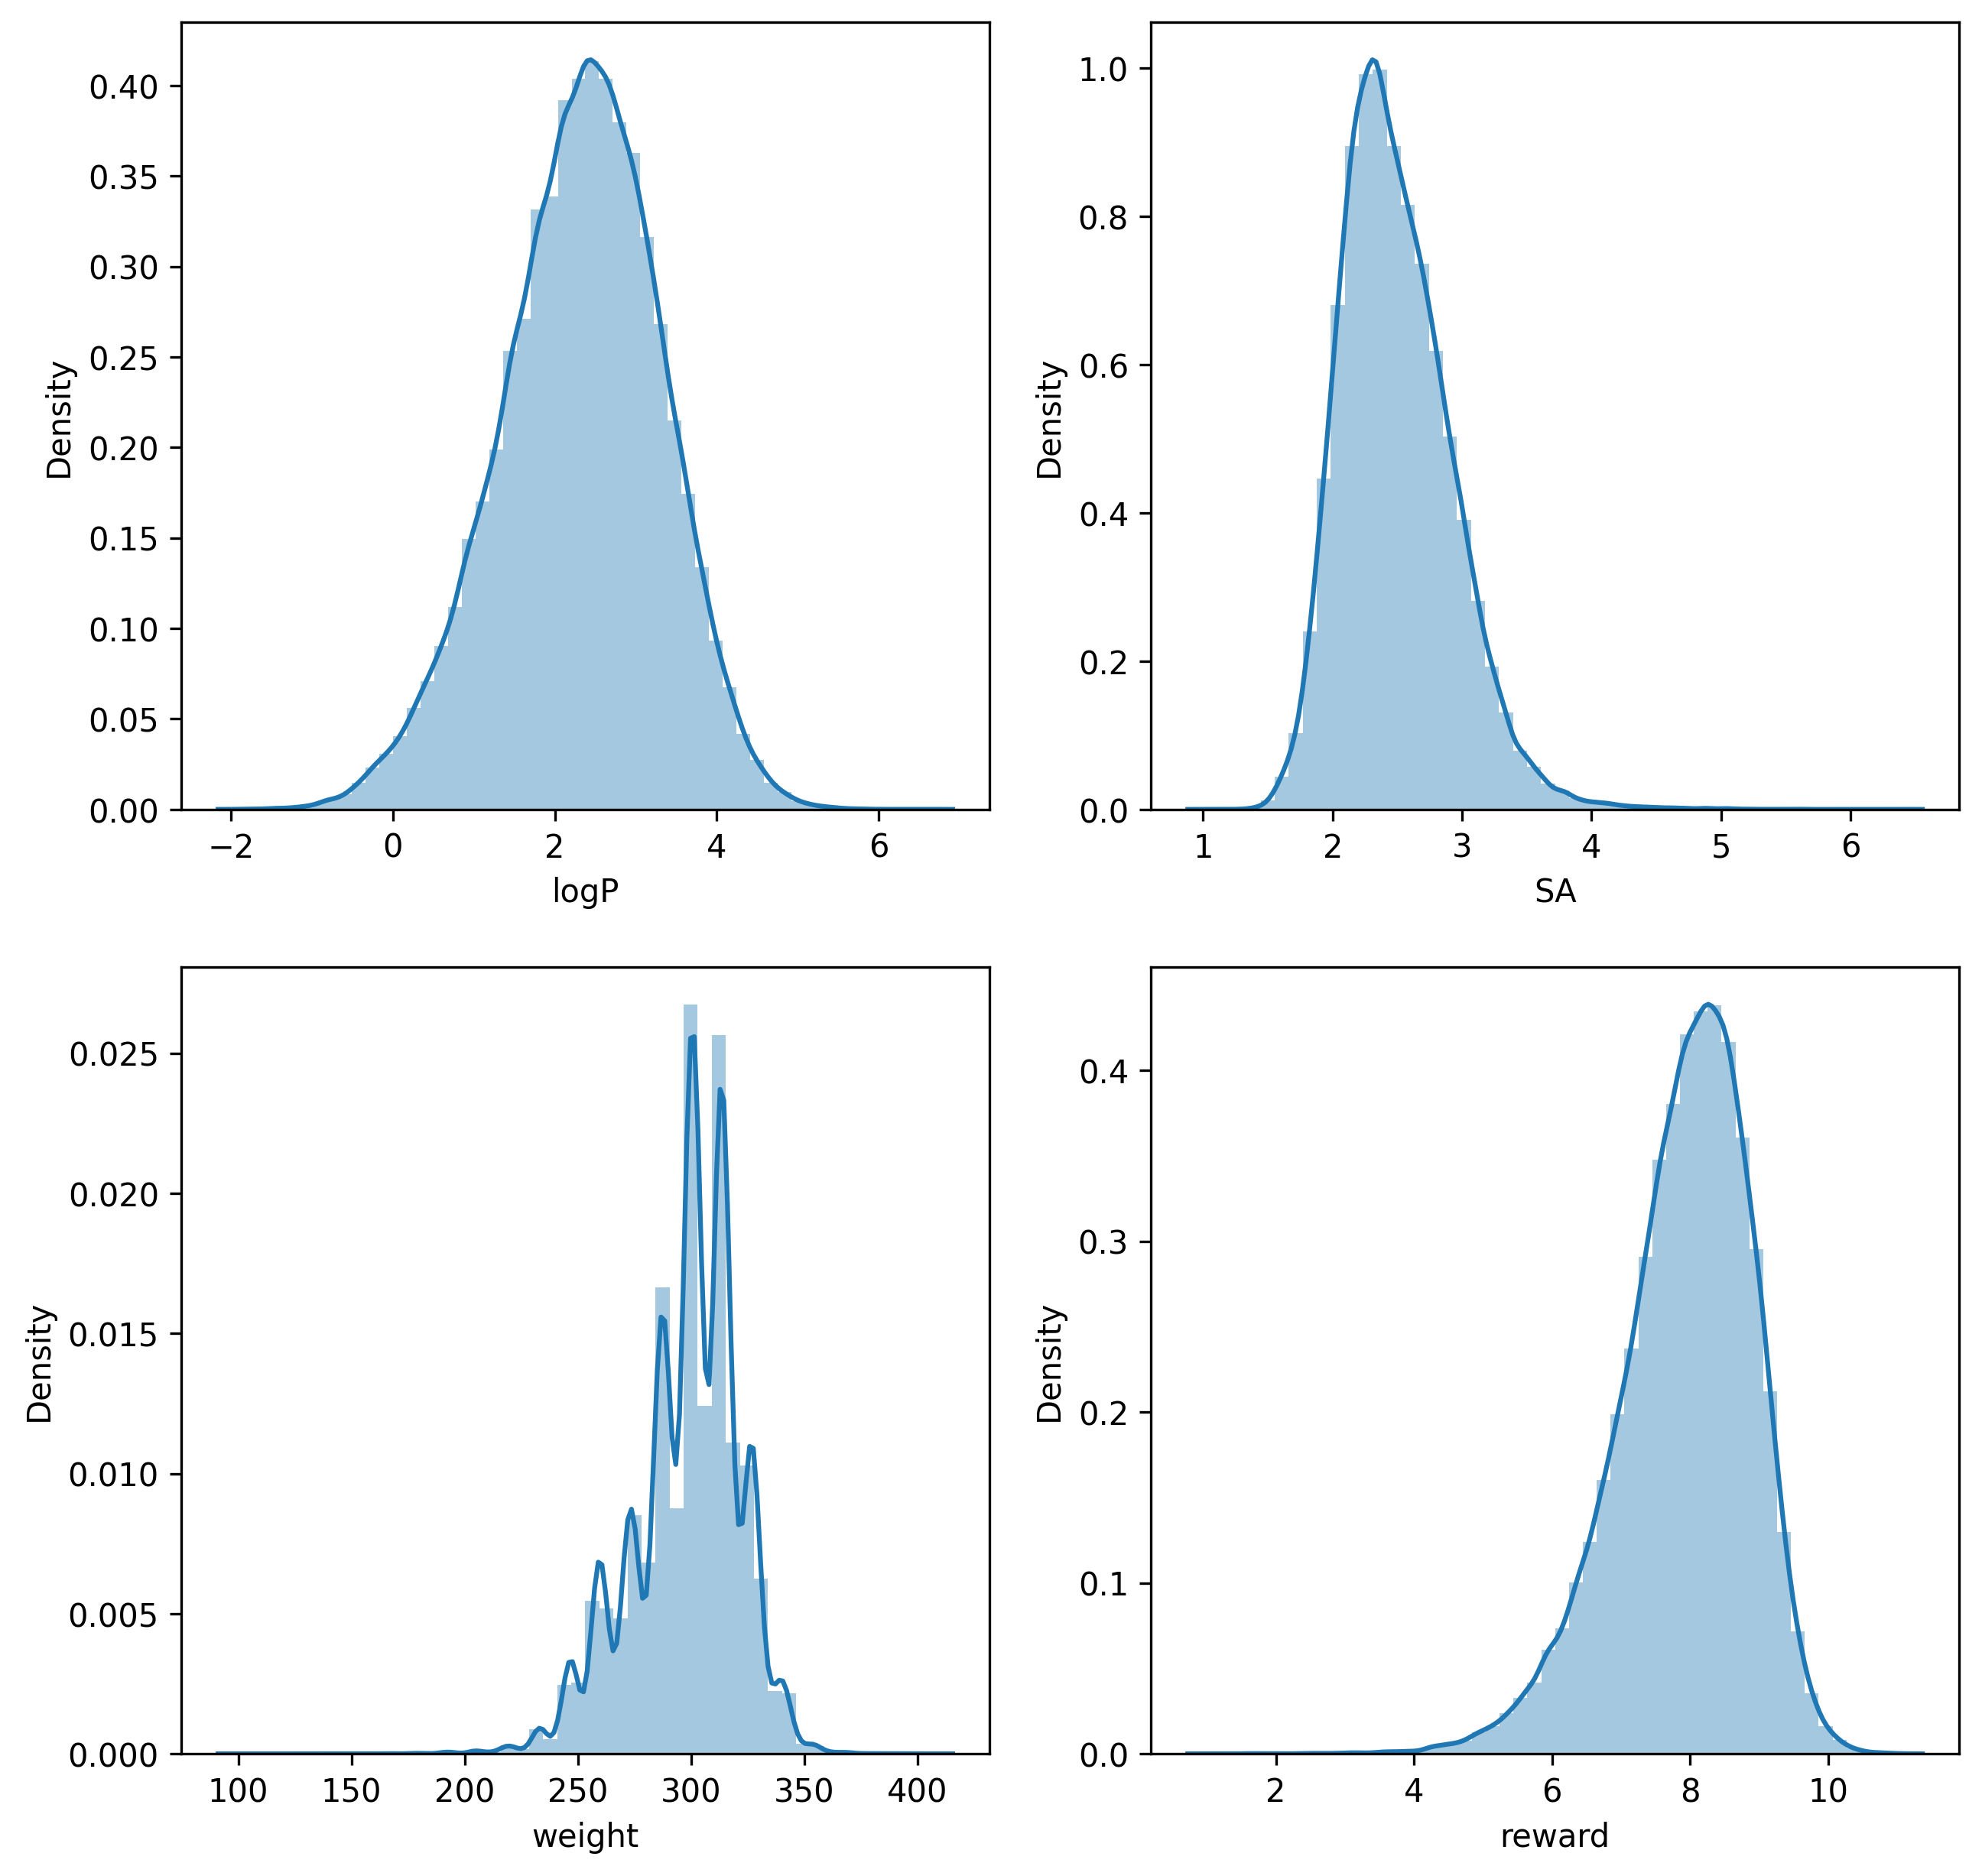

In [58]:
plt.figure(figsize=(10,10), dpi=300)
plt.subplot(2, 2, 1)
sns.distplot(df['logP'])
plt.subplot(2, 2, 2)
sns.distplot(df['SA'])
plt.subplot(2, 2, 3)
sns.distplot(df['weight'])
plt.subplot(2, 2, 4)
sns.distplot(df['reward'])
plt.show()

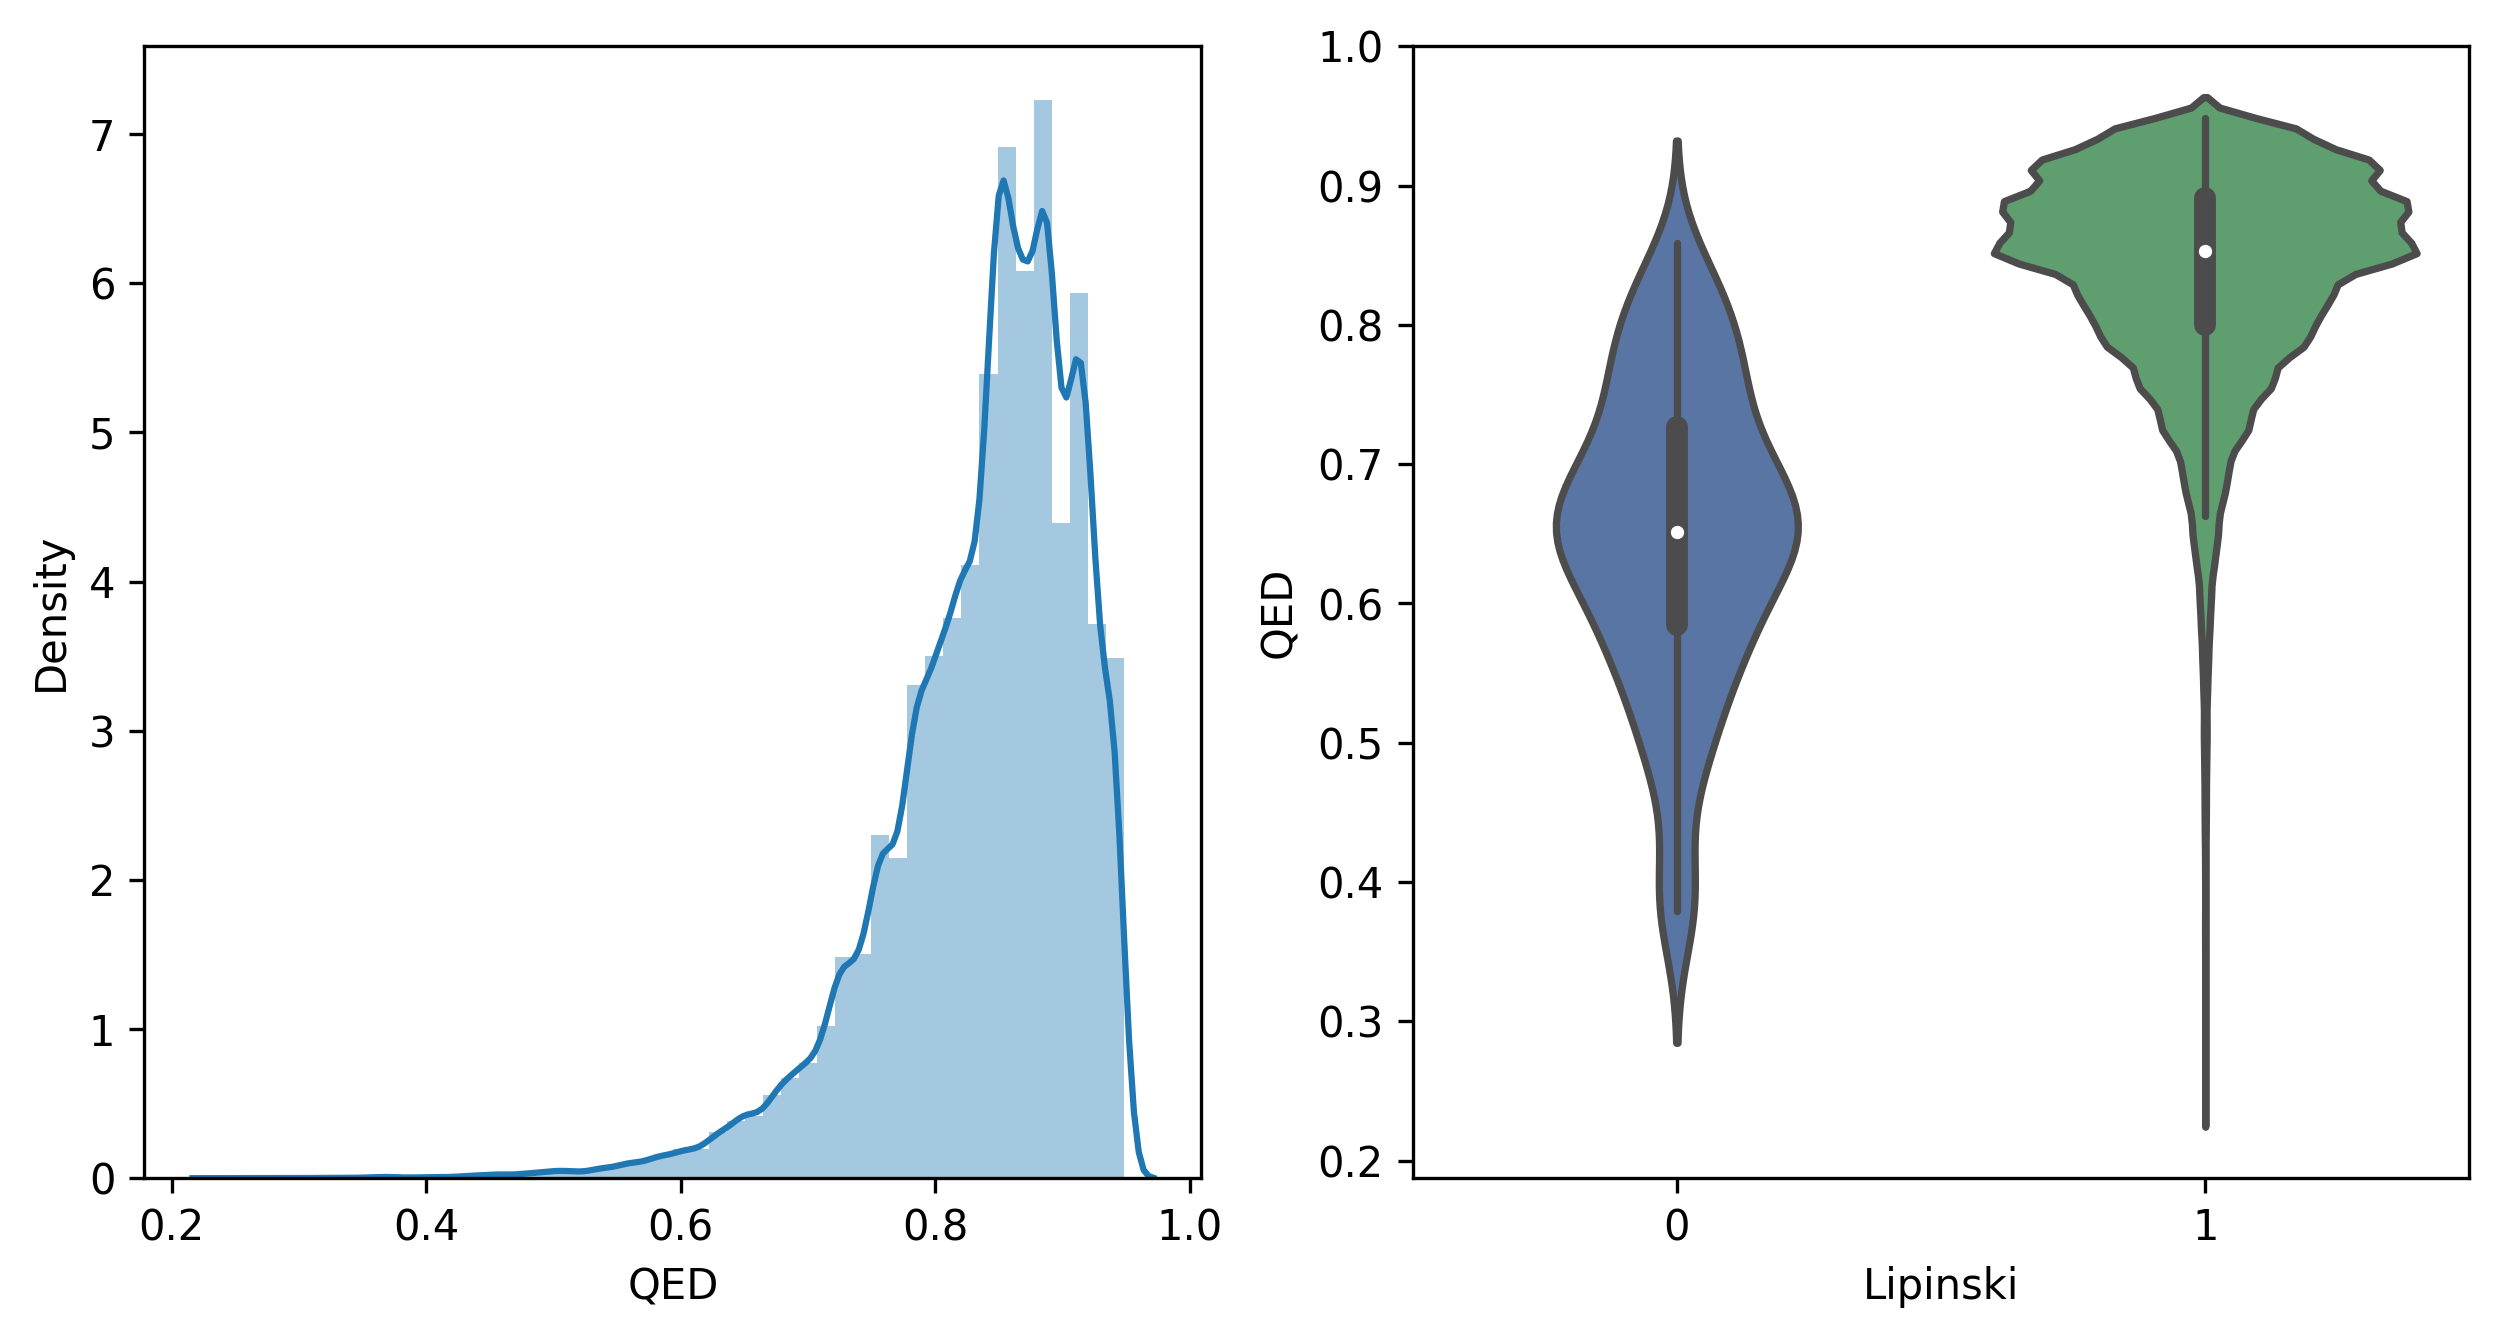

In [63]:
import seaborn as sns
plt.figure(figsize=(10,5), dpi=300)
plt.subplot(1, 2, 1)
sns.distplot(df['QED'])
plt.subplot(1, 2, 2)
with plt.style.context('seaborn'):
  sns.violinplot(x='Lipinski', y='QED', data=df)